In [0]:
###initialize imports and dataset
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c conda-forge rdkit
#!conda install pytorch torchvision cudatoolkit=9.0 -c pytorch -y
#!pip3 install pyro-ppl

!conda install -y --prefix /usr/local -c conda-forge rdkit joblib simdna
!git clone https://github.com/deepchem/deepchem.git      # Clone deepchem source code from GitHub
!cd deepchem && python setup.py install
!ls -la /usr/local/lib/python3.7/site-packages/deepchem

#!pip install -q tf-nightly-2.0-preview
#%load_ext tensorboard

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import math
import numpy as np
import pandas as pd
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.data import data_loader
import random
random.seed(0)
import pickle
import matplotlib.pyplot as plt
#import tensorflow as tf
#import datetime

In [0]:
###shouldn't need to do this because the ground truth is in drive now
from google.colab import files
uploaded = files.upload()

In [0]:
from google.colab import drive
drive.mount("drive")

In [0]:
# Clear any logs from previous runs
#!rm -rf ./logs/

#log_dir="./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [37]:
dataset_file = "drive/My Drive/ADD19 Datasets/enamineSubset10KGroundTruth.csv"

ground_truth_dataset = pd.read_csv(dataset_file)

low_bace_dataset = ground_truth_dataset.sort_values(by="bace")[:2500] #take 2.5K worst binder potential starters,shouldn't need copy

top_5_percent_index = len(ground_truth_dataset) // 20
top_5_percent_bace_cutoff = ground_truth_dataset.sort_values(by="bace", ascending=False)["bace"][top_5_percent_index]

print("Cutoff bace score for 95th percentile:", top_5_percent_bace_cutoff)
print("Columns of dataset: %s" % str(ground_truth_dataset.columns.values))
print("Number of examples in dataset: %s" % str(ground_truth_dataset.shape[0]))

Cutoff bace score for 95th percentile: 4.870083
Columns of dataset: ['Index' 'SMILES' 'bace' 'esol' 'logD']
Number of examples in dataset: 10000


In [0]:
###featurized ground truth for scoring
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)
dataset_feat = loader.featurize(dataset_file) #featurize the molecules from the ground truth dataset
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
ground_truth_for_scoring = transformer.transform(dataset_feat)

In [0]:
###initialize ground truth models and methods to access them

def load_oracle_models():
    """Loads the pretrained ground truth models for evaluating molecules' properties on-the-fly.
    
    Returns
    -------
    oracle : dict
        A dictionary containing models mapped to their property keywords: "bace", "esol", "logD".
    """
    bace_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/bace")
    esol_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/esol")
    logD_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/logD")
    bace_model.restore()
    esol_model.restore()
    logD_model.restore()
    oracle = {"bace":bace_model, "esol":esol_model, "logD":logD_model} #get each model via the named property
    return oracle

def query_oracle(dataset, oracle):
    """Evaluate molecules on-the-fly for their estimated bace, esol, and logD scores.
    
    Parameters
    ----------
    dataset : pandas.DataFrame
        The input dataset; must includes a field with smiles strings under keyword "SMILES".
    oracle : dictionary( dc.models.GraphConvModel )
        The pretrained ground truth value prediction models.
        
    Returns
    -------
    results : pandas.DataFrame
        Copy of input dataset with newly estimated bace, esol, and logD scores under those headers. 
    """
    query_file = "./temp/oracle_eval.csv"
    dataset.to_csv(query_file)
    
    results = dataset.copy(deep=True) #defensive copy of input dataframe 
    
    featurizer = dc.feat.ConvMolFeaturizer()
    for prop in ("bace", "esol", "logD"):
        #retrieve appropriate model from oracle
        model = oracle[prop]
        
        #load, featurize, and normalize input dataset
        loader = dc.data.CSVLoader(tasks=[prop], smiles_field="SMILES",featurizer=featurizer)
        dataset_feat = loader.featurize(query_file)
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)
        
        #predict and assign property results to keyword
        predicted = model.predict(dataset_feat)
        results[prop] = predicted
        
    return results

In [0]:
###define Abstract Data Type to hold search information, including ensemble

class Experimenter():
    """Class representing a research scientist/team going through the drug development process.
    
    Parameters
    ----------
    N : int
        Number of samples to initially train the experimenter ensemble on.
    M : int
        Number of molecules to purchase in each batch.
    ensemble_size : int, optional
        Number of models in experimenter ensemble.
    epochs : int, optional
        Number of epochs to train ensemble models for at each stage.
    molecule_cost : int or float, optional
        Monetary cost of purchasing a single molecule.
    target_bounds : dictionary of str:tuples(floats), optional
        Desired range for each property.
    sampling_mode : string {"thompson", "highest mean", "random"}
        The means of choosing the ensemble outputs/molecules.
    
    Attributes
    ----------
    ensemble : dictionary of deepchem.models.GrachConvModel
        Models representing the experimenter knowledge/predictions and uncertainty.
    history : list of dictionaries storing model attributes
        Snapshots of the model state at each time step.
    samples_seen : pandas.DataFrame
        Ground truth values of the molecules seen before. Includes initial training set.
    smiles_seen : list of str
        SMILES strings of the molecules seen before.
    predictions : pandas.DataFrame
        Predicted values of entire dataset at this time step.
    cost : int or float
        Total monetary cost incurred at the current time.
    number_molecules : int
        Total number of molecules purchased at the current time.
    time : int
        Total number of days spent up to the current time.
        
    """
    def __init__(self, N, M, ensemble_size=3, epochs=1, molecule_cost=200,
                 target_bounds={"bace":(4, math.inf), "esol":(-5, math.inf), "logD":(-0.4, 5.6)}, sampling_method="highest mean"):
        self.N = N #initial samples
        self.M = M #batch size
        self.ensemble_size = ensemble_size
        self.epochs = epochs
        self.molecule_cost = molecule_cost
        self.target_bounds = target_bounds
        if sampling_method == "thompson" or sampling_method == "highest mean" or sampling_method == "random":
            self.sampling_method = sampling_method
        else:
            raise ValueError("Input for sampling method was not allowed argument. Choices are thompson, highest mean, and random.")
        
        self.ensemble = {i:dc.models.GraphConvModel(n_tasks=3, mode='regression', batch_size=20, random_seed=i, tensorboard=True) 
                         for i in range(self.ensemble_size)} #map each model to its seed
        self.history = [] #save snapshot of model, on disk
        self.samples_seen = None
        self.predicted = None
        self.smiles_seen = []
        self.predictions = pd.DataFrame()
        self.cost = 0
        self.number_molecules = 0
        self.time = 0 #days
        
        
    def train_model(self, model, dataset):
        """Helper function to train a given ensemble model on a given dataset.
        
        Parameters
        ----------
        model : Keras model (generally deepchem.GraphConvModel)
            Model to be trained.
        dataset : pandas.DataFrame
            Dataset to train on. Must include "SMILES", "bace", "esol", and "logD" headers.
            
        """
        #convert DataFrame to CSV and read in as deepchem.Dataset via deepchem.CSVLoader
        
        #dataset_temp_file = "./temp/training_dataset.csv"
        dataset.to_csv("training_dataset.csv")
        
        !cp training_dataset.csv drive/My\ Drive/


        featurizer = dc.feat.ConvMolFeaturizer()
        loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)

        #dataset_feat = loader.featurize(dataset_temp_file)
        dataset_feat = loader.featurize("training_dataset.csv")
        
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)

        model.fit(dataset_feat, nb_epoch=1, deterministic=True, restore=False)
    
    
    def train_ensemble(self, dataset):
        """Helper function to train model ensemble.
        
        Parameters
        ----------
        dataset : pandas.Dataset
            Dataset on which to train models. Must include "SMILES", "bace", "esol", and "logD" headers.
        
        """
        for model in self.ensemble.values():
            self.train_model(model, dataset)

    
    def initial_training(self, verbose=False):
        """Train model ensemble for the first time on self.N samples randomly chosen from the 2500 lowest bace affinity-scored 
        molecules.
        
        Parameters
        ----------
        verbose : bool
            Whether to print progress updates.
        
        Notes
        -----
        If self.N > 2500, ensemble will be trained on 2500 samples.
        Records first history object.
        
        """
        idx_range = self.N if self.N < low_bace_dataset.shape[0] else low_bace_dataset.shape[0]
        rand_indices = random.sample(range(low_bace_dataset.shape[0]), k=idx_range) #select random row indices
        
        init_ensemble_dataset = pd.DataFrame()
        for idx in rand_indices:
            init_ensemble_dataset = init_ensemble_dataset.append( low_bace_dataset.iloc[idx], ignore_index=True )
        
        if verbose:
            print("Training set selected.")
            
        self.samples_seen = init_ensemble_dataset ### collect the examples seen during initial training (ground truth values)
        self.smiles_seen = init_ensemble_dataset["SMILES"].tolist()
        
        #cost/time to initially train? free initial knowledge?
        self.cost += self.molecule_cost * len(init_ensemble_dataset)
        self.number_molecules += len(init_ensemble_dataset)
        self.time = 0
        

        if self.sampling_method != "random":
            if verbose:
                print("Training ensemble...")
            self.train_ensemble(init_ensemble_dataset) #train ensemble on initial dataset, unless we are randomly sampling and do not need to        
            if verbose:
                print("Ensemble trained.")
                
        self.record_history()

                
    def get_component_score(self, arr, keys):
        """Helper function to get the scaled "goodness" of the input scores.
        
        Parameters
        ----------
        array : numpy.array
             Array with bace, esol, and logD scores.
        keys : collection of strings from {"bace", "esol", "logD"}
            Which scores to incorporate into the overall goodness.
        
        Returns
        -------
        numpy.array
            Sum of component scores.
        
        """
        scores = []
        if "bace" in keys:
            #higher bace => higher score
            bace = arr[:,0]
            bace_range = self.target_bounds["bace"]
            scores.append( np.where(bace < bace_range[0], 0.2*bace-0.8, 0.05*bace-0.2) )
            #dec penalty when score>low end of range
        
        if "esol" in keys:
            esol = arr[:,1]
            esol_range = self.target_bounds["esol"]
            scores.append( np.where(esol < esol_range[0], esol - np.absolute(esol-esol_range[1])**2, esol) )
        
        if "logD" in keys:
            #logD within range is not penalized
            logD = arr[:,2]
            logD_range = self.target_bounds["logD"]
            #handle lower end of range
            int_arr = np.where(logD < logD_range[0], logD - np.absolute(logD-logD_range[0]), logD)
            #handle upper end of range
            scores.append(np.where(int_arr > logD_range[1], int_arr - np.absolute(int_arr-logD_range[1]), int_arr) )

        return sum(scores)
        
    
    def score_and_select_top(self):
        """Scores all molecules and selects the top M for "purchase".
        
        """
        #featurizer = dc.feat.ConvMolFeaturizer()
        #loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)
        #dataset_feat = loader.featurize(dataset_file) #featurize the molecules from the ground truth dataset
        #transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        #dataset_feat = transformer.transform(dataset_feat)
        
        if self.sampling_method == "highest mean":
            #take the average of model predictions
            predicted = np.zeros( (len(ground_truth_for_scoring),3) )
            for model in self.ensemble.values():
                predicted += model.predict(ground_truth_for_scoring)
            predicted /= len(self.ensemble) 
            
        elif self.sampling_method == "thompson":
            #Thompson sampling
            predictions = [model.predict(ground_truth_for_scoring) for model in self.ensemble.values()] #generate all preds to choose from, don't think we can avoid this step by doing 1 row at a time (large overhead)
            selected_rows = []
            rand_pred_idx_range = len(self.ensemble) - 1 #random.randint range is inclusive on both ends
            
            for row_idx in range( len(ground_truth_for_scoring) ):
                pred_idx = random.randint(0, rand_pred_idx_range) #select random prediction array to get row from
                pred_array = predictions[pred_idx]
                pred_row = pred_array[row_idx]
                selected_rows.append(pred_row)
            predicted = np.vstack(selected_rows) #collect and concatenate rows    
            #TODO nice to visualize spread of predictions here?
        
        
        elif self.sampling_method == "random":
            ###randomly select up to M points from those not seen
            unseen = ground_truth_dataset.loc[~ground_truth_dataset['SMILES'].isin(self.smiles_seen)] #remove prev seen
            unseen = unseen.iloc[np.random.permutation(len(unseen))] #shuffle remaining samples
            unseen = unseen[:self.M] if (len(unseen) > self.M) else unseen #select up to self.M samples
            
            self.samples_seen = pd.concat([self.samples_seen,unseen], sort=False)
            self.smiles_seen = self.samples_seen["SMILES"].tolist()
            self.cost += self.molecule_cost * len(unseen)
            self.number_molecules += len(unseen)
            self.time += 28 #4 weeks to buy and experiment             
            return 
            
            
        #copy SMILES and assign calculated scores, store in self.predictions
        results_df = pd.DataFrame()
        results_df["SMILES"] = ground_truth_dataset["SMILES"]   
        goodness = self.get_component_score(predicted, ["bace", "esol", "logD"])
        results_df["bace"] = predicted[:,0]
        results_df["esol"] = predicted[:,1]
        results_df["logD"] = predicted[:,2]
        results_df["goodness"] = goodness
        self.predictions = results_df
        
        unseen_predicted_rows = results_df.loc[~results_df['SMILES'].isin(self.smiles_seen)] #also remove predicted values previously seen
        unseen_predicted_rows = unseen_predicted_rows.sort_values(by="goodness", ascending=False) #sort predictions with highest goodness at top
        
        predicted_subset = unseen_predicted_rows[:self.M] if (len(unseen_predicted_rows) > self.M) else unseen_predicted_rows #select up to self.M samples from the predictions
        predicted_subset_smiles = predicted_subset["SMILES"].tolist()
        
        new_batch_ground_truth = ground_truth_dataset.loc[ground_truth_dataset['SMILES'].isin(predicted_subset_smiles)]
        
        self.samples_seen = pd.concat([self.samples_seen,new_batch_ground_truth], sort=False)
        self.smiles_seen = self.samples_seen["SMILES"].tolist()
        self.cost += self.molecule_cost * len(new_batch_ground_truth)
        self.number_molecules += len(new_batch_ground_truth)
        self.time += 28 #4 weeks to buy and experiment
        
        
        ###TODO: implement scatter plots for predicted vs GT, track R2s?
        
    
    def record_history(self):
        """Stores model costs and experience for later analysis.
        
        Notes
        -----
        Does not save self.history attribute, in order to avoid redundantly storing the data in it.
        Only saves attributes that change in each time step.
        
        """
        hist = {}
        hist["samples_seen"] = self.samples_seen
        hist["smiles_seen"] = self.smiles_seen
        hist["cost"] = self.cost
        hist["number_molecules"] = self.number_molecules
        hist["time"] = self.time
        hist["predictions"] = self.predictions
        self.history.append(hist)
     

    def run(self):
        """Simple wrapper to automate calls to select molecules and update models. 
        
        Returns
        -------
        candidates : pandas.DataFrame
            The candidate compounds that satisfy the given criteria.

        Notes
        -----
        Must be preceded by initial training of model ensemble.
        
        """        
        while len(self.samples_seen) < len(ground_truth_dataset): #replace with top bace score to exit -> 4.87(approx 95th %ile)
            candidates = self.samples_seen.loc[self.samples_seen['bace'] >= top_5_percent_bace_cutoff] #find mols w/ high bace
            
            esol_lower_bound = self.target_bounds["esol"][0]
            candidates = candidates.loc[candidates['esol'] >= esol_lower_bound] #filter the insoluble mols
            
            logD_range = self.target_bounds["logD"]
            candidates = candidates.loc[( candidates['logD'] >= logD_range[0] ) 
                                                 & ( candidates['logD'] <= logD_range[1] )] #filter for logD in range
              
            if len(candidates) > 0:
                print("Molecule within bounds and 95th percentile bace affinity found.")
                return candidates
                
            self.score_and_select_top()
            self.record_history()
            self.train_ensemble(self.samples_seen)

In [0]:
"""
Step 1: load ground truth models and ensemble

Step 2: train ensemble on N random data points (including ground truth values)

Step 3: score all of the 10K molecules using the ensemble

Step 4: take ("buy") the top M, and "assess them experimentally" (get their ground truth values)

Step 5: add those samples to the training/seen set

Step 6: retrain the ensemble

Step 7: repeat (make 2-6 repeatable)

Step 8: add some loops over N and M to generate plots of Hx vs N,M
"""

In [0]:
### ADD %%prun command to cell below to run and time with profiler

In [51]:
%%prun
#N = [96, 384, 1536] #initial train set size
N = [96]
#M = [96, 384, 1536] #batch size -> 96 wells, multiples
M = [96]

models = []

for n in N:
    for m in M:
        e = Experimenter(n, m, ensemble_size=5, sampling_method='thompson')
        models.append(e)
        e.initial_training()
        top_mols = e.run()

Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.344 s
TIMING: dataset construction took 0.396 s
Loading dataset from disk.
TIMING: dataset construction took 0.050 s
Loading dataset from disk.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.13938
TIMING: model fitting took 25.841 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.341 s
TIMING: dataset construction took 0.393 s
Loading dataset from disk.
TIMING: dataset construction took 0.050 s
Loading dataset from disk.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.06586
TIMING: model fitting took 26.590 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.354 s
TIMING: dataset construction took 0.407 s
Loading dataset from disk.
TIMING: dataset construction took 0.048 s
Loading dataset from disk.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.08279
TIMING: model fitting took 27.134 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.363 s
TIMING: dataset construction took 0.416 s
Loading dataset from disk.
TIMING: dataset construction took 0.050 s
Loading dataset from disk.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.61066
TIMING: model fitting took 28.369 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.346 s
TIMING: dataset construction took 0.401 s
Loading dataset from disk.
TIMING: dataset construction took 0.049 s
Loading dataset from disk.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.44254
TIMING: model fitting took 31.132 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.707 s
TIMING: dataset construction took 0.798 s
Loading dataset from disk.
TIMING: dataset construction took 0.107 s
Loading dataset from disk.
Ending global_step 15: Average loss 0.952331
TIMING: model fitting took 4.371 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.708 s
TIMING: dataset construction took 0.803 s
Loading dataset from disk.
TIMING: dataset construction took 0.099 s
Loading dataset from disk.
Ending global_step 15: Average loss 0.982027
TIMING: model fitting took 6.973 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from training_dataset.csv
Loading shard 1 

In [0]:
%tensorboard --logdir logs/fit

192


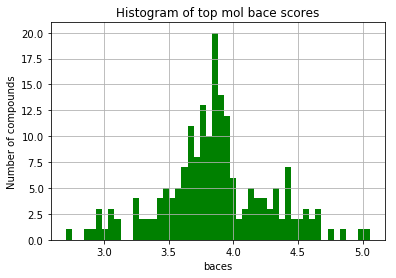

In [52]:
top_mols
print(e.history[1]["number_molecules"])

baces = np.array(e.history[1]["samples_seen"]["bace"])
n, bins, patches = plt.hist(baces, 50, facecolor='green')

plt.xlabel('baces')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of top mol bace scores')
plt.grid(True)
plt.show()

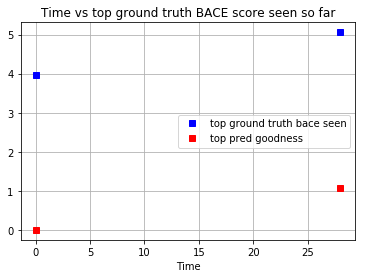

In [53]:
for model in models:
    costs = []
    times = []
    top_gt_bace_scores = []
    goodnesses = []
    
    for hx in model.history:
        costs.append(hx["cost"])
        times.append(hx["time"])
        top_gt_bace_scores.append(hx["samples_seen"]["bace"].max()) #max ground truth score seen
        if hx["predictions"].empty:
            goodnesses.append(0)
        else:
            goodnesses.append( hx["predictions"]["goodness"].max() ) #max predicted goodness so far

plt.plot(times,top_gt_bace_scores,'bs',label="top ground truth bace seen")
plt.plot(times,goodnesses,'rs',label="top pred goodness")

plt.xlabel('Time')
plt.title(r'Time vs top ground truth BACE score seen so far')
plt.grid(True)
plt.legend()
plt.show()

2.3942474999999996
2.3942474999999996


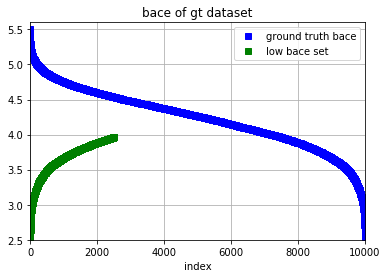

In [44]:
gt_bace = ground_truth_dataset["bace"].tolist()
low_bace = low_bace_dataset["bace"].tolist()

x = [i for i in range(len(gt_bace))]
print(min(gt_bace))
print(gt_bace[-1])

plt.clf()
plt.xlim([0,10000])
plt.ylim([2.5,5.6])

plt.plot(x,gt_bace,'bs',label="ground truth bace")
plt.plot(x[:2500],low_bace,'gs',label="low bace set")

plt.xlabel('index')
plt.title(r'bace of gt dataset')
plt.grid(True)
plt.legend()
plt.show()